In [1]:
#First load necessary modules
import numpy as np
import pandas as pd
import os

import matplotlib.pylab as plt



At the beginnng we want to load our dataset

In [3]:
import numpy as np
import pandas as pd
import os

#load the data
file_name_test = "data/test/finaltestdata.csv"
file_name_train = "data/train/finaltraindata.csv"
column_names = ["mouth distance", "right eye area", "left eye area", "mouth area", "right eye to eyelash distance", "left eye to eyelash distance", "nose height", "nose width", "mouth to nose distance", "mouth to chin distance", "head width", "mouth to eye area ratio", "left to right eye ratio", "mouth-chin angle", "eye-nose angle","emotion as integer"]

if os.path.exists(file_name_test):
    print(f'Loading data from local file `{file_name_test}`...')
    df_test = pd.read_csv(file_name_test, names = column_names, header=None)
else:
    print('No test data found')

if os.path.exists(file_name_train):
    print(f'Loading data from local file `{file_name_train}`...')
    df_train = pd.read_csv(file_name_train, names = column_names, header=None)
else:
    print('No train data found')
    
df_test
#df_train

Loading data from local file `data/test/finaltestdata.csv`...
Loading data from local file `data/train/finaltraindata.csv`...


,mouth distance,right eye area,left eye area,mouth area,right eye to eyelash distance,left eye to eyelash distance,nose height,nose width,mouth to nose distance,mouth to chin distance,head width,mouth to eye area ratio,left to right eye ratio,mouth-chin angle,eye-nose angle,emotion as integer
0,82.000000,1291.5,1233.5,20222.5,51.946708,58.096597,192.634577,129.348283,26.305893,52.354560,505.284079,0.124861,0.894144,66.291362,76.944777,0
1,15.000000,876.0,868.5,3393.5,50.712792,48.461249,129.158936,69.865869,42.011903,75.166482,364.137337,0.514071,1.046461,74.768404,87.775568,0
2,83.000000,633.5,628.0,13984.0,39.659682,37.357342,145.271817,105.065432,24.020824,57.035077,420.233269,0.090210,1.061630,52.745317,76.391523,0
3,30.805844,1911.5,1991.5,13420.0,56.155777,59.377501,156.197480,115.436728,36.359318,54.129474,472.969344,0.290835,0.945742,78.619921,89.180579,0
4,35.000000,1165.0,1144.5,7926.5,35.927589,34.613154,147.043171,99.508335,33.015148,75.059976,381.996073,0.291364,1.037975,61.959363,78.018463,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4829,12.041595,1867.0,1846.5,7000.0,55.724270,52.144962,154.237741,80.289830,59.000000,73.824115,430.029069,0.530500,1.068642,67.955469,88.035870,6
4830,64.070274,1560.0,1378.0,10321.5,68.161018,62.694956,126.335757,80.420090,29.068884,69.180922,394.001269,0.284649,1.087185,56.066344,91.233527,6
4831,52.345009,1176.0,1296.0,10884.0,49.383968,53.543887,129.880984,81.061477,26.248809,62.936476,351.647551,0.227122,0.922308,61.585811,84.552279,6
4832,22.022716,1650.5,1852.5,4594.5,53.767311,54.636371,110.411160,61.737796,37.336309,57.706152,374.370138,0.762433,0.984094,67.590982,95.208011,6


We can skip the train-test split and instead just shuffle our data

In [4]:
#shuffle
df_test = df_test.sample(frac=1).reset_index(drop=True)
df_train = df_train.sample(frac=1).reset_index(drop=True)


maybe now visualize some data points

Now load all models and utils form courselib

In [5]:
from AppliedML.courselib.optimizers import GDOptimizer

In [6]:
from AppliedML.courselib.models.linear_models import LinearMulticlassClassification

In [7]:
from AppliedML.courselib.utils.metrics import accuracy, mean_squared_error

In [8]:
# use this function to prepare our data for the multiclass classifier
def prepare_df(df):

    X_train = df.iloc[:, :15]

    #to normalize, extract maxima and check for division by zero
    col_max = X_train.max(axis=0)                  
    col_max[col_max == 0] = 1                   

    X_train = (X_train / col_max).to_numpy()

    #Now we want to make y into a N x K matrix
    y = df.iloc[:, 15].astype(int).values  # shape (N,), values 0..6

    classes = np.unique(y)           # array([0,1,2,3,4,5,6])
    K = len(classes)                 # 7

    # map labels to 0..6 (though they already are)
    label_to_idx = {c: c for c in classes}
    y_idx = np.vectorize(label_to_idx.get)(y)

    # one-hot in {0,1}
    Y_onehot = np.zeros((len(y_idx), K))
    Y_onehot[np.arange(len(y_idx)), y_idx] = 1

    # now to get labels -1 and 1
    y_test = 2 * Y_onehot - 1 

    return X_train, y_test

X_train, y_train = prepare_df(df_test)

Now we want to initialze our models

In [21]:
d = X_train.shape[1]                  # 15 features
w0 = np.zeros((d, 7))           # shape (15, 7)
b0 = np.zeros((1, 7))           # shape (1, 7)

metrics_dict = {
    "accuracy": accuracy,
    "loss": mean_squared_error
}

optimizer = GDOptimizer(learning_rate=0.1)  
model = LinearMulticlassClassification(w=w0, b=b0, optimizer=optimizer)

metrics_history = model.fit(X_train, y_train, num_epochs=10000, batch_size=len(X_train), compute_metrics=True, metrics_dict=metrics_dict)


Now prepare test data and evalute on it 

In [22]:

X_test = df_test.iloc[:, :15]

col_max = X_test.max(axis=0)                    
col_max[col_max == 0] = 1                   

X_test = (X_test / col_max).to_numpy()

y_test = df_test.iloc[:,15].to_numpy(dtype=int)

prediction = model(X_test)             


Now plot loss and accuracy

[np.float64(0.5), np.float64(0.3194696072905223), np.float64(0.26224802916430107), np.float64(0.24402803661087252), np.float64(0.23814450620432823), np.float64(0.2361636512564993), np.float64(0.23541798452269785), np.float64(0.23506381316297636), np.float64(0.23483428330851655), np.float64(0.2346449866900766), np.float64(0.23446921990732905), np.float64(0.23429853079924948), np.float64(0.23413023985017697), np.float64(0.23396349339658723), np.float64(0.23379801531495), np.float64(0.23363371219883455), np.float64(0.23347054848191454), np.float64(0.23330850694083097), np.float64(0.23314757620243184), np.float64(0.23298774679209572), np.float64(0.2328290098834766), np.float64(0.23267135690267027), np.float64(0.23251477940262574), np.float64(0.2323592690230339), np.float64(0.23220481747725455), np.float64(0.23205141654779896), np.float64(0.2318990580845211), np.float64(0.23174773400366894), np.float64(0.23159743628721133), np.float64(0.23144815698225424), np.float64(0.23129988820048936), n

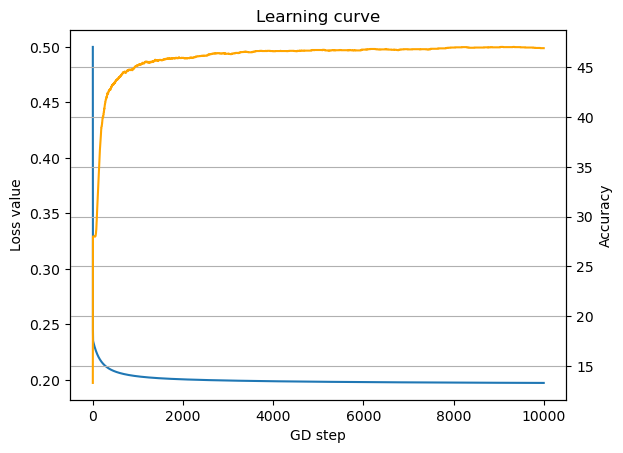

In [23]:
fig, ax = plt.subplots()
print(metrics_history['loss'])

ax.plot(range(len(metrics_history['loss'])), metrics_history['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('GD step')

plt.title('Learning curve')
plt.grid()

print(f"The final train accuracy: {round(metrics_history['accuracy'][-1],1)}%")
print(f"Test accuracy: {round(accuracy(prediction, y_test, one_hot_encoded_labels=False),1)}%")

In [20]:
from AppliedML.courselib.utils.metrics import plot_confusion_matrix

def confusion_matrix(y_true, y_pred, num_classes=None):

    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    
    if num_classes is None:
        num_classes = max(y_true.max(), y_pred.max()) + 1
    
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        if 0 <= t < num_classes and 0 <= p < num_classes:
            cm[t, p] += 1
        else:
            raise ValueError(f"Labels out of range: true={t}, pred={p}")
    return cm


4834
(4834,)


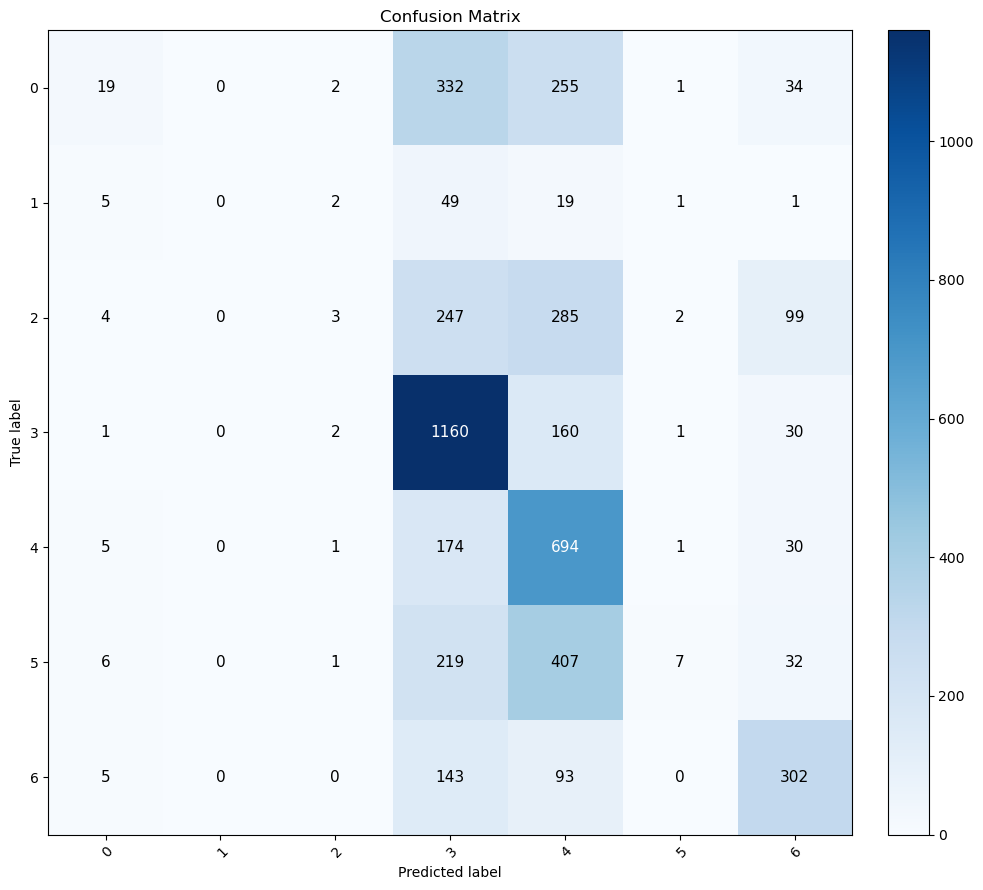

In [14]:

print(y_test.shape[-1])
print(prediction.shape)
plot_confusion_matrix(confusion_matrix(y_test, prediction), 
                      class_names=None,
                      figsize=(10,9))

Now we want to test if each class has the same amount of training data

In [15]:
#class 2 has the least amount of images
count = (df_test["emotion as integer"] == 1).sum()

label_col = df_test.columns[15]

#take as many pictures from each class as there are in class 2
df_test_equal = (df_test.groupby(label_col, group_keys=False).sample(n=count, random_state=42))
print(len(df_test_equal))



539


In [16]:
#prepare the equally spit data
X_equal, y_equal = prepare_df(df_test_equal)

In [17]:
#Now train a new model with the data
model_equal = LinearMulticlassClassification(w=w0, b=b0, optimizer=optimizer)

# fit for, say, 1000 steps or until convergence
metrics_history_equal = model_equal.fit(X_equal, y_equal, num_epochs=1000, batch_size=len(X_equal), compute_metrics=True, metrics_dict=metrics_dict)

pred_idxs_equal = model_equal(X_test)

The final train accuracy: 42.1%
Test accuracy: 41.7%


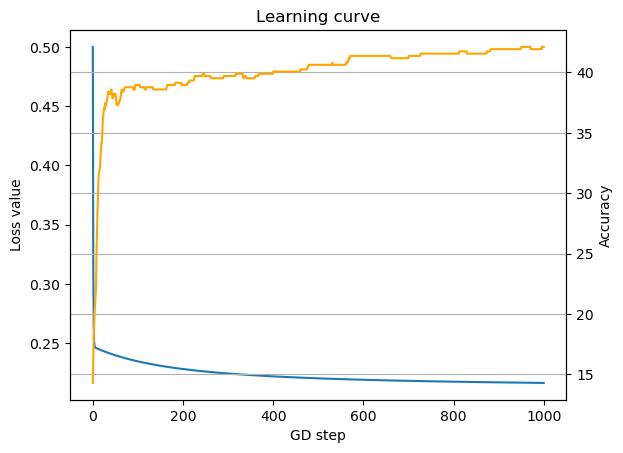

In [18]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history_equal['loss'])), metrics_history_equal['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history_equal['accuracy'])), metrics_history_equal['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('GD step')

plt.title('Learning curve')
plt.grid()

print(f"The final train accuracy: {round(metrics_history_equal['accuracy'][-1],1)}%")
print(f"Test accuracy: {round(accuracy(model_equal(X_test), y_test, one_hot_encoded_labels = False),1)}%")

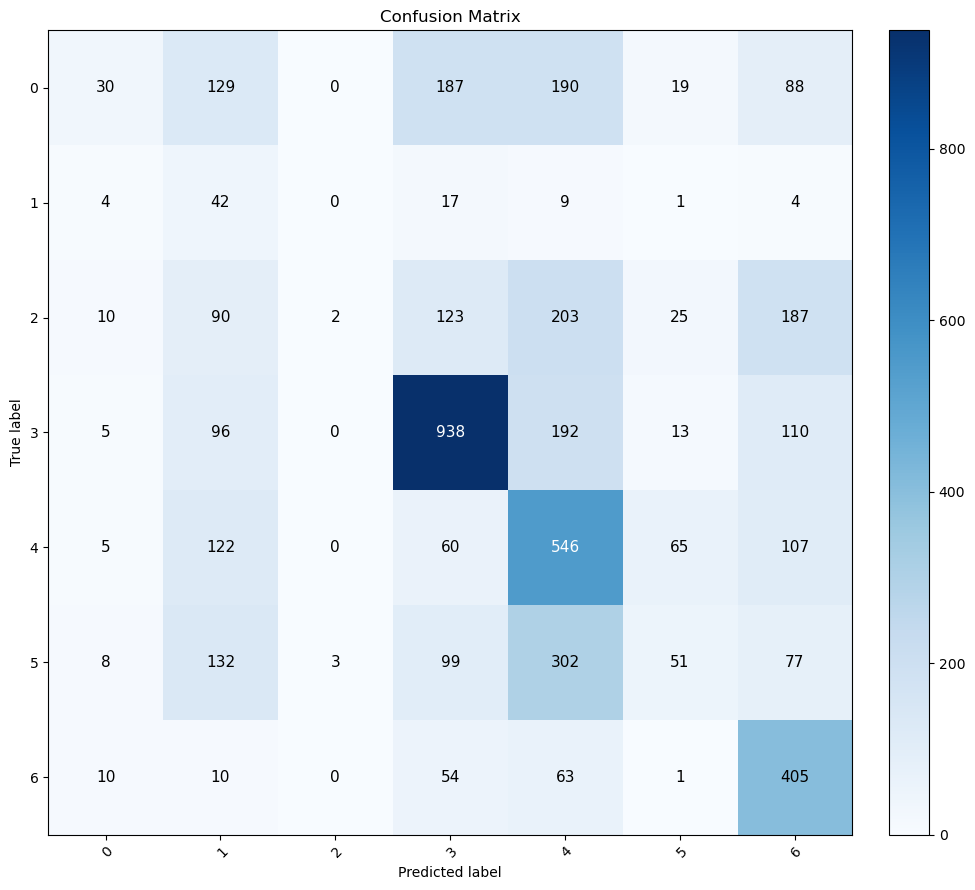

In [19]:
plot_confusion_matrix(confusion_matrix(y_test, pred_idxs_equal), 
                      class_names=None,
                      figsize=(10,9))